<a href="https://colab.research.google.com/github/FGalvao77/-DICAS-Uso-de-ferramentas-para-Data-Science-e-afins/blob/main/processamento_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install spacy==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 10.2 MB/s 
     |████████████████████████████████| 821 kB 37.1 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.1
    Uninstalling spacy-3.3.1:
      Successfully uninstalled spacy-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 3.4.0 which is incompatible.


In [3]:
!pip install emoji==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import re
import os
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

%matplotlib inline

In [5]:
print(
    '\tVERSÃO',
    f'- Spacy: {spacy.__version__}',
    f'- Emoji: {emoji.__version__}', 
    sep='\n'
)

	VERSÃO
- Spacy: 3.4.0
- Emoji: 1.7.0


# Webscraping

criando função para fazer dataset de texto a partir de 3 editorias determinadas no site.

In [6]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [7]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Twitter uses Musk's old poop reaction to CEO's...,Twitter has used Tesla CEO Elon Musk's poop re...,technology
1,"Russian space agency chief Dmitry, known for c...","Dmitry Rogozin, the Russian space agency chief...",technology
2,Will prove our position in court & we believe ...,Following a lawsuit against Tesla CEO Elon Mus...,technology
3,Elon has a real record of success: LinkedIn Co...,LinkedIn's billionaire Co-founder Reid Hoffman...,technology
4,Unjustifiable request: Musk files motion again...,Tesla CEO Elon Musk has filed a motion opposin...,technology
5,Twitter's lawsuit against Musk gets 90-min 1st...,Twitter’s lawsuit against Tesla CEO Elon Musk ...,technology
6,Musk accused lawyers of causing trouble by see...,"In its lawsuit against Tesla CEO Elon Musk, Tw...",technology
7,MHA website ranks 1st among central ministry s...,The Ministry of Home Affairs has ranked first ...,technology
8,Twitter down for thousands of users across the...,Twitter is down for thousands of users across ...,technology
9,It is not a sacrifice at all: Bill Gates on pl...,"Microsoft Co-founder Bill Gates, who plans to ...",technology


In [8]:
news_df.to_csv('news_df_mentorama.csv')

Para saber:

- *Token*: uma unidade do texto, pode ser uma palavra, uma frase, etc. 
- *Documento*: uma sequencia de tokens, por exemplo um livro ou um artigo 
- *Corpus*: um conjunto de documentos. 
- *Document Term Matrix*: uma matrix que descreve a frequencia de termos em um corpus
- *Stopwords*: palavras que não contém informação, que ocorrem com muita frequência.

Definindo função que processa o texto e retorna o texto tokenizado e sem stopwords, emoji, pontuação e números, etc:

In [9]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.UNICODE_EMOJI])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [10]:
rows, cols = news_df.shape
rows, cols

(75, 3)

In [11]:
#processando os textos
news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [12]:
news_df.head()

,news_headline,news_article,news_category,token
0,Twitter uses Musk's old poop reaction to CEO's...,Twitter has used Tesla CEO Elon Musk's poop re...,technology,"[twitter, used, tesla, ceo, elon, musk, poop, ..."
1,"Russian space agency chief Dmitry, known for c...","Dmitry Rogozin, the Russian space agency chief...",technology,"[dmitry, rogozin, russian, space, agency, chie..."
2,Will prove our position in court & we believe ...,Following a lawsuit against Tesla CEO Elon Mus...,technology,"[following, lawsuit, tesla, ceo, elon, musk, b..."
3,Elon has a real record of success: LinkedIn Co...,LinkedIn's billionaire Co-founder Reid Hoffman...,technology,"[linkedin, billionaire, founder, reid, hoffman..."
4,Unjustifiable request: Musk files motion again...,Tesla CEO Elon Musk has filed a motion opposin...,technology,"[tesla, ceo, elon, musk, filed, motion, opposi..."


# Word Embedding

Depois que temos o texto com tokens, vamos usar uma rede neural que recebe palavras e entrega vetores que representam ela em um espaço vetorial. 

# documentação importante:
https://spacy.io/usage

In [13]:
!python -m spacy download en_core_web_md

2022-07-17 23:55:33.990963: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [14]:
import spacy

In [15]:
nlp = spacy.load('en_core_web_md')

In [16]:
# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

# Vetorizando cada palavra. 
Aqui, como cada documento tem um número diferente de palavras, vamos ter matrizes com diferentes dimensões. Nosso objetivo final é conseguir representar cada documento como um vetor que resume o documento. Ou seja, queremos representar diferentes matrizes como vetores. Existem várias formas de fazer isso (média dos vetores, média ponderada pelo TF-IDF, PCA...), mas nesse teste vamos fazer uma média simples. 

In [17]:
vec_size = 300
list_of_matrix = []

for corpus in news_df['token']:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

In [18]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [19]:
final_feature_matrix.shape

(75, 300)

# Clusterização de matérias:

Agora que temos um vetor que representa cada documento, vamos usar algum método de clusterização pra tentar recuperar as editorias selecionadas lá no início. Vamos rodar um k-means em cada vetor que representa um documento e (como é um teste), pedir 3 clusters para ele. 

In [20]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0).fit(final_feature_matrix)
kmeans.labels_

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 2], dtype=int32)

Vamos ver como o k-means separou cada grupo e olhar o label verdadeiro para validar nosso método:

In [21]:
print(news_df["news_category"][kmeans.labels_ == 0]) 
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

25    sports
26    sports
27    sports
28    sports
29    sports
30    sports
31    sports
32    sports
33    sports
34    sports
35    sports
36    sports
37    sports
38    sports
39    sports
40    sports
41    sports
42    sports
43    sports
44    sports
45    sports
46    sports
47    sports
48    sports
49    sports
Name: news_category, dtype: object
0     technology
1     technology
2     technology
4     technology
5     technology
6     technology
7     technology
8     technology
9     technology
10    technology
11    technology
12    technology
13    technology
14    technology
15    technology
16    technology
17    technology
18    technology
19    technology
20    technology
21    technology
22    technology
23    technology
24    technology
52         world
55         world
57         world
58         world
67         world
73         world
Name: news_category, dtype: object
3     technology
50         world
51         world
53         world
54         world
56        

Conseguimos separar bem as editorias por assuntos.

# Notícia mais similar usando distância euclidiana

Vamos agora tentar identificar, dado um documento, qual é o documento mais similar a ele. 

In [22]:
def get_closest(list_of_articles, article_position, df):
    article_vec = list_of_articles[article_position,:]
    other_vec = np.delete(list_of_articles, article_position, 0)
    from scipy import spatial
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    print(df[article_position])
    print(df[closest_position])
    return tree.query(article_vec)[0], closest_position

In [23]:
get_closest(final_feature_matrix, 30, news_df["news_article"])

Virat Kohli on Sunday got out for 17 runs in the third ODI against England, aggregating 33 runs in the series. Kohli's fewest runs in a bilateral ODI series had come against Pakistan in 2012-2013, when he scored 13 runs in three innings. It is followed by 26 runs in three innings against West Indies earlier this year.
After India bowled out England for 259 in 45.5 overs in third ODI at Old Trafford, Wasim Jaffer said, "Can't remember last time England were so tied down in a home series." He added, "Boom [Jasprit Bumrah] wasn't there today but Hardik Pandya stepped [in] and how." All-rounder Hardik posted 4/24 in seven overs, his best-ever bowling figures in ODIs.


(13.726875139681034, 43)

# Explorando visualmente os resultados encontrados

Como estamos lidando com uma dimensão elevada (300) para cada documento, não conseguimos visualizar com clareza o que estamos clusterizando. Um método simples que permite explorar os resultados obtidos é reduzir a dimensão do problema para 2, 3 e fazer gráficos exploratórios que permitam visualizar os dados.


In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])

In [27]:
pca.explained_variance_ratio_

array([0.24493905, 0.10395481])

Aqui, vamos plotar o gráfico dos dois primeiros componentes e colorir eles com a cor associada à editoria real dele.

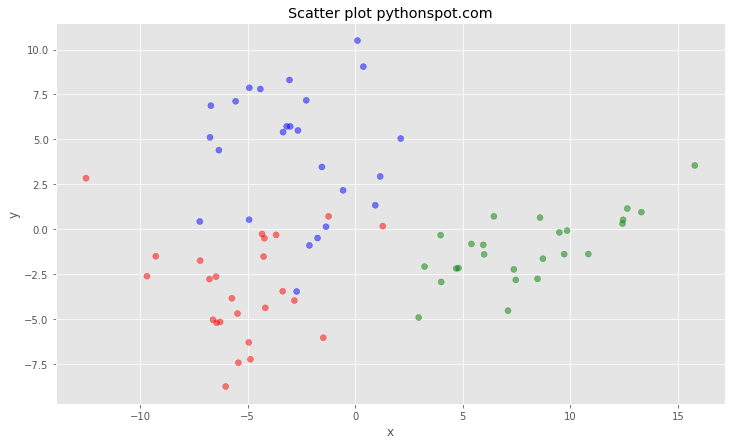

In [28]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,7)

# Create data

x = principalDf['principal component 1']
y = principalDf['principal component 2']

# Plot

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()